<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/train_ddpg_multi_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib tensorflow

  Using cached gym_anytrading-2.0.0-py3-none-any.whl.metadata (292 bytes)
  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 48.8 MB/s eta 0:00:00
Using cached gym_anytrading-2.0.0-py3-none-any.whl (172 kB)
Using cached stable_baselines3-2.6.0-py3-none-any.whl (184 kB)


In [6]:
!pip uninstall -y dask cudf-cu12 cuml-cu12 rapids-dask-dependency pylibraft-cu12 pylibcudf-cu12 numba stable-baselines3 gymnasium gym-anytrading

Found existing installation: stable_baselines3 2.6.0
Uninstalling stable_baselines3-2.6.0:
  Successfully uninstalled stable_baselines3-2.6.0
Found existing installation: gymnasium 1.1.1
Uninstalling gymnasium-1.1.1:
  Successfully uninstalled gymnasium-1.1.1
Found existing installation: gym-anytrading 2.0.0
Uninstalling gym-anytrading-2.0.0:
  Successfully uninstalled gym-anytrading-2.0.0


In [7]:
!pip install --upgrade --force-reinstall \
    dask==2024.11.2 \
    rapids-dask-dependency==24.12.0 \
    cudf-cu12==24.12.0 \
    cuml-cu12==24.12.0 \
    pylibraft-cu12==24.12.0 \
    pylibcudf-cu12==24.12.0 \
    numba==0.61.0 \
    stable-baselines3[extra] \
    gymnasium==0.29.1 \
    gym-anytrading==2.0.0


  Using cached dask-2024.11.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached rapids_dask_dependency-24.12.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached cudf_cu12-24.12.0-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (6.2 kB)
  Using cached cuml_cu12-24.12.0.tar.gz (2.5 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pylibraft_cu12-24.12.0.tar.gz (5.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pylibcudf_cu12-24.12.0-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (4.9 kB)
  Using cached numba-0.61.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached gym_anytrading-2.0.0-py3-none-any.whl.metadata (292 bytes)
  Using c

In [8]:
import cudf, cuml, dask, stable_baselines3, gymnasium
import numba, pandas, numpy, scipy

print("cuDF Version:", cudf.__version__)
print("cuML Version:", cuml.__version__)
print("Dask Version:", dask.__version__)
print("Stable Baselines3 Installed:", stable_baselines3.__version__)
print("Gymnasium Version:", gymnasium.__version__)
print("NumPy Version:", numpy.__version__)
print("SciPy Version:", scipy.__version__)
print("Pandas Version:", pandas.__version__)

ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)

In [1]:
!nvidia-smi

Thu Apr 10 23:33:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
print("TF Version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TF Version: 2.18.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#Step 2: Set Environment Paths for CUDA 11.8
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.8/lib64'

In [3]:

try:
    df = cudf.DataFrame({'col1': [1, 2, 3], 'col2': [4, 5, 6]})
    print("cuDF is working and using GPU!")
except Exception as e:
    print(f"cuDF GPU check failed: {e}")



cuDF GPU check failed: name 'cudf' is not defined


In [5]:
import os
import time
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
import yfinance as yf
import gymnasium as gym  #Use gymnasium instead of gym
import gym_anytrading
from gymnasium.envs.registration import registry, register
import matplotlib.pyplot as plt

#Prevent cuDF from taking all GPU memory
os.environ["RAPIDS_NO_INITIALIZE"] = "1"

#RAPIDS & GPU-based Libraries (Try-Except to Avoid CPU Errors)
try:
    import cudf
    import cuml
    from cuml.ensemble import RandomForestClassifier
    from cuml.metrics import accuracy_score
    GPU_AVAILABLE = True
    print("cuDF & cuML are available and running on GPU.")
except ImportError:
    print("cuDF/cuML not available. Switching to CPU mode.")
    GPU_AVAILABLE = False

#Reinforcement Learning & Trading
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#TensorFlow & GPU Optimization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#Ensure TensorFlow GPU Memory Allocation is Configured
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  #Prevents full allocation
        print("TensorFlow GPU memory growth enabled")
    except RuntimeError as e:
        print(f"TensorFlow GPU memory issue: {e}")

#Google Drive Access (for Colab)
from google.colab import drive


cuDF & cuML are available and running on GPU.
TensorFlow GPU memory growth enabled


In [12]:
import os
import time
import numpy as np
import pandas as pd
import yfinance as yf

#Ticker List
ticker_list = [
    'AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'JPM', 'JNJ',
    'XOM', 'V', 'PG', 'UNH', 'MA', 'HD', 'LLY', 'MRK', 'PEP', 'KO',
    'BAC', 'ABBV', 'AVGO', 'PFE', 'COST', 'CSCO', 'TMO', 'ABT', 'ACN', 'WMT',
    'MCD', 'ADBE', 'DHR', 'CRM', 'NKE', 'INTC', 'QCOM', 'NEE', 'AMD', 'TXN',
    'AMGN', 'UPS', 'LIN', 'PM', 'UNP', 'BMY', 'LOW', 'RTX', 'CVX', 'IBM',
    'GE', 'SBUX', 'ORCL'
]

CONFIG = {
    'period': '720d',
    'interval': '1h',
    'strategy_name': "sac_ppo_td3_multi_stock_v1"
}

#1.Download Stock Data
def download_stock_data(ticker, period="720d", interval="1h", max_retries=5):
    for attempt in range(1, max_retries + 1):
        try:
            print(f"Attempt {attempt}: Downloading {ticker}...")
            df = yf.download(ticker, period=period, interval=interval)
            if not df.empty:
                df.reset_index(inplace=True)
                df['Symbol'] = ticker
                return df
            raise ValueError("Empty data")
        except Exception as e:
            print(f"Error: {e}. Retrying in {attempt * 5} sec...")
            time.sleep(attempt * 5)
    print(f"Failed to download {ticker}")
    return None

#2.Feature Engineering
def compute_enhanced_features(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df.loc[:, ~df.columns.duplicated()]

    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['STD_20'] = df['Close'].rolling(20).std()
    df['Upper_Band'] = df['SMA_20'] + 2 * df['STD_20']
    df['Lower_Band'] = df['SMA_20'] - 2 * df['STD_20']
    df['Lowest_Low'] = df['Low'].rolling(14).min()
    df['Highest_High'] = df['High'].rolling(14).max()
    denom = (df['Highest_High'] - df['Lowest_Low']).replace(0, np.nan)
    df['Stoch'] = ((df['Close'] - df['Lowest_Low']) / denom) * 100
    df['ROC'] = df['Close'].pct_change(10)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())
    df['PROC'] = ((df['Close'] - df['Close'].shift(12)) / df['Close'].shift(12)) * 100
    df['Rolling_Mean_50'] = df['Close'].rolling(50).mean()
    df['Expanding_Mean'] = df['Close'].expanding().mean()
    df['EMA_10'] = df['Close'].ewm(span=10).mean()
    df['EMA_50'] = df['Close'].ewm(span=50).mean()
    df['MACD_Line'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['MACD_Signal'] = df['MACD_Line'].ewm(span=9).mean()
    df['MACD_Hist'] = df['MACD_Line'] - df['MACD_Signal']
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['True_Range'] = df[['High', 'Low', 'Close']].apply(
        lambda x: max(x.iloc[0] - x.iloc[1], abs(x.iloc[0] - x.iloc[2]), abs(x.iloc[1] - x.iloc[2])), axis=1)
    df['ATR'] = df['True_Range'].rolling(14).mean()
    df['+DM'] = np.where((df['High'].diff() > df['Low'].diff()) & (df['High'].diff() > 0), df['High'].diff(), 0)
    df['-DM'] = np.where((df['Low'].diff() > df['High'].diff()) & (df['Low'].diff() > 0), df['Low'].diff(), 0)
    df['+DI'] = 100 * df['+DM'].rolling(14).mean() / df['ATR']
    df['-DI'] = 100 * df['-DM'].rolling(14).mean() / df['ATR']
    df['ADX'] = abs(df['+DI'] - df['-DI']).rolling(14).mean()
    df['Volume_Avg'] = df['Volume'].rolling(20).mean()
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_Change_MA'] = df['Volume_Change'].rolling(10).mean()
    df['Volume_Change_Ratio'] = df['Volume_Change'] / df['Volume_Change'].shift(1)
    df['Relative_Volume'] = df['Volume'] / df['Volume_Avg']
    df['Trailing_Stop'] = np.minimum(df['Close'] * 0.985, df['Close'] - (df['ATR'] * 0.3))
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

#3.Label Creation
def create_trading_labels(df, label_type="multiclass", return_threshold=0.02, shift_period=10):
    df = df.copy()
    df['Future_Close'] = df['Close'].shift(-shift_period)
    df['Return'] = (df['Future_Close'] - df['Close']) / df['Close']

    if label_type == "multiclass":
        df['Target'] = np.select(
            [df['Return'] > return_threshold, df['Return'] < -return_threshold],
            [1, -1],
            default=0
        )
    elif label_type == "binary":
        df['Target'] = np.where(df['Return'] > return_threshold, 1, 0)
    elif label_type == "regression":
        df['Target'] = df['Return']
    else:
        raise ValueError("Invalid label_type. Use 'multiclass', 'binary', or 'regression'.")

    df.drop(columns=["Future_Close", "Return"], inplace=True, errors='ignore')
    return df

#4.Run Pipeline for All Stocks
all_dfs = []

for ticker in ticker_list:
    df_single = download_stock_data(ticker, period=CONFIG['period'], interval=CONFIG['interval'])
    if df_single is not None:
        try:
            df_features = compute_enhanced_features(df_single)
            df_features['Symbol'] = ticker
            df_labeled = create_trading_labels(df_features, label_type="multiclass")
            all_dfs.append(df_labeled)
        except Exception as e:
            print(f"Feature engineering or labeling failed for {ticker}: {e}")
    else:
        print(f"Failed to download {ticker}")

#5. Combine & Save
if all_dfs:
    df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined dataset created with shape: {df.shape}")
    df.to_csv("multi_stock_feature_engineered_dataset.csv", index=False)
    print("Saved locally as multi_stock_feature_engineered_dataset.csv")

    #Google Drive path (optional)
    drive_path = "/content/drive/MyDrive/trading_data/"
    os.makedirs(drive_path, exist_ok=True)
    df.to_csv(os.path.join(drive_path, "multi_stock_feature_engineered_dataset.csv"), index=False)
    print(f"Also saved to: {drive_path}multi_stock_feature_engineered_dataset.csv")
else:
    print("No data was processed.")


Attempt 1: Downloading AAPL...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading TSLA...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading MSFT...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading GOOGL...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading AMZN...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading NVDA...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading META...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading BRK-B...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading JPM...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading JNJ...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading XOM...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading V...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading PG...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading UNH...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading MA...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading HD...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading LLY...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading MRK...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading PEP...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading KO...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading BAC...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading ABBV...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading AVGO...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading PFE...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading COST...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading CSCO...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading TMO...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading ABT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Attempt 1: Downloading ACN...


Attempt 1: Downloading WMT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Attempt 1: Downloading MCD...


Attempt 1: Downloading ADBE...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading DHR...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading CRM...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading NKE...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading INTC...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading QCOM...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading NEE...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading AMD...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading TXN...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading AMGN...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading UPS...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading LIN...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading PM...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading UNP...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading BMY...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading LOW...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading RTX...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading CVX...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading IBM...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading GE...


[*********************100%***********************]  1 of 1 completed


Attempt 1: Downloading SBUX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Attempt 1: Downloading ORCL...


Combined dataset created with shape: (262857, 40)
Saved locally as multi_stock_feature_engineered_dataset.csv
Also saved to: /content/drive/MyDrive/trading_data/multi_stock_feature_engineered_dataset.csv


In [13]:
#Ensure Column Names Are Flattened Correctly
df.columns = df.columns.get_level_values(0) if isinstance(df.columns, pd.MultiIndex) else df.columns

#Remove Named Index (if exists)
df.columns.name = None  #Remove 'Price' as the column index name

#Verify Columns After Processing
print("Final Columns in df:", df.columns)

#Ensure 'Close' Exists Before Proceeding
if 'Close' not in df.columns:
    raise KeyError("Column 'Close' not found in the DataFrame after processing.")

#Load Your Dataset
data = df.copy()  #Ensure 'df' is loaded before this step

#Add Technical Indicators (RSI & MACD)
def compute_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))  #Compute RSI
    return rsi  #Return computed RSI values

def compute_macd(data, short=12, long=26, signal=9):
    short_ema = data['Close'].ewm(span=short, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['MACD_Signal'] = data['MACD'].ewm(span=signal, adjust=False).mean()

#aaply Indicators to `data`
data['RSI'] = compute_rsi(data)  #Ensure RSI is assigned properly
compute_macd(data)  #Compute MACD in place

#Drop NaN values to avoid errors in training
data.dropna(inplace=True)

#Verify if 'RSI' column exists
print(data.head())  #Print first few rows to check if RSI is present

#Drop non-numeric columns before normalization (keep index intact)
data_numeric = data.select_dtypes(include=[np.number])  #Keep only numeric columns

#Normalize only numeric data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_numeric)

#Convert back to DataFrame and retain the original index
scaled_df = pd.DataFrame(scaled_data, columns=data_numeric.columns, index=data.index)

#Check if the data looks correct
print(scaled_df.head())


Final Columns in df: Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'Symbol',
       'SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band', 'Lowest_Low',
       'Highest_High', 'Stoch', 'ROC', 'OBV', 'CCI', 'PROC', 'Rolling_Mean_50',
       'Expanding_Mean', 'EMA_10', 'EMA_50', 'MACD_Line', 'MACD_Signal',
       'MACD_Hist', 'RSI', 'True_Range', 'ATR', '+DM', '-DM', '+DI', '-DI',
       'ADX', 'Volume_Avg', 'Volume_Change', 'Volume_Change_MA',
       'Volume_Change_Ratio', 'Relative_Volume', 'Trailing_Stop', 'Target'],
      dtype='object')
                    Datetime       Close        High         Low        Open  \
13 2022-06-09 19:30:00+00:00  142.600006  143.800003  142.529999  143.619995   
14 2022-06-10 13:30:00+00:00  137.490005  140.759995  137.460007  140.250000   
15 2022-06-10 14:30:00+00:00  137.399994  138.539001  137.270004  137.489899   
16 2022-06-10 15:30:00+00:00  137.975006  138.070007  137.289993  137.410995   
17 2022-06-10 16:30:00+00:00  138.089996  138.

In [14]:
gc.collect

<function gc.collect(generation=2)>

In [15]:
results_df = pd.DataFrame(results)
results_df.to_csv("td3_multi_stock_results.csv", index=False)


In [16]:
import gc
import torch
import numpy as np
import pandas as pd
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
from gym_anytrading.envs.stocks_env import StocksEnv
from gymnasium.spaces import Box

#CONFIG ===
tickers = df["Symbol"].unique().tolist()  #Use existing dataset
window_size = 10
initial_balance = 100000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
results = []

#Custom Environment ===
class ContinuousTradingEnv(StocksEnv):
    def __init__(self, df, frame_bound, window_size):
        super().__init__(df=df, frame_bound=frame_bound, window_size=window_size)
        self.action_space = Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = action[0]
        if action < -0.3:
            discrete_action = 0  #SELL
        elif action > 0.3:
            discrete_action = 1  #BUY
        else:
            discrete_action = 2  #HOLD
        return super().step(discrete_action)

#Main Loop ===
for ticker in tickers:
    print(f"\nRunning DDPG for: {ticker}")
    try:
        df_ticker = df[df["Symbol"] == ticker].copy().reset_index(drop=True)

        if df_ticker.shape[0] < 100:
            print(f"Skipping {ticker}: insufficient data.")
            continue

        frame_bound = (50, len(df_ticker))
        env = DummyVecEnv([lambda: ContinuousTradingEnv(df_ticker, frame_bound, window_size)])
        n_actions = env.action_space.shape[-1]
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

        model = DDPG(
            "MlpPolicy",
            env,
            learning_rate=2e-4,
            buffer_size=100000,
            batch_size=128,
            gamma=0.99,
            tau=0.01,
            verbose=0,
            device=device,
            action_noise=action_noise
        )

        model.learn(total_timesteps=5000)

        #Inference & Portfolio Tracking ===
        obs = env.reset()
        trade_log = []
        balance = initial_balance
        position = 0
        portfolio = []
        buy_price = None

        for i in range(len(df_ticker) - 50):
            action, _ = model.predict(obs)
            price = df_ticker['Close'].iloc[i + 50]

            if action > 0.3 and buy_price is None:
                trade_log.append("BUY")
                buy_price = price
                position = balance / price
                balance = 0
            elif action < -0.3 and buy_price is not None:
                trade_log.append("SELL")
                balance = position * price
                position = 0
                buy_price = None
            else:
                trade_log.append("HOLD")

            value = balance if balance > 0 else position * price
            portfolio.append(value)

        #Metrics ===
        final_value = portfolio[-1]
        buy_hold = (initial_balance / df_ticker['Close'].iloc[50]) * df_ticker['Close'].iloc[-1]
        cumulative_return = ((final_value / initial_balance) - 1) * 100
        daily_returns = pd.Series(portfolio).pct_change().fillna(0)
        sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() != 0 else 0
        max_dd = (pd.Series(portfolio).cummax() - pd.Series(portfolio)).max() / pd.Series(portfolio).cummax().max() * 100

        results.append({
            "Ticker": ticker,
            "DDPG Final": round(final_value, 2),
            "BuyHold Final": round(buy_hold, 2),
            "Return %": round(cumulative_return, 2),
            "Sharpe": round(sharpe, 2),
            "Max DD %": round(max_dd, 2),
            "Winner": "DDPG" if final_value > buy_hold else "Buy & Hold"
        })

        if len(results) % 5 == 0:
            pd.DataFrame(results).to_csv("ddpg_partial_results.csv", index=False)

        del model, env
        gc.collect()
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error with {ticker}: {e}")
        continue

#Save Results ===
results_df = pd.DataFrame(results)
results_df.to_csv("ddpg_multi_stock_results.csv", index=False)
print("\nDDPG multi-stock training complete. Results saved.")
print(results_df.sort_values(by="Return %", ascending=False).head())



Running DDPG for: AAPL

Running DDPG for: TSLA

Running DDPG for: MSFT

Running DDPG for: GOOGL

Running DDPG for: AMZN

Running DDPG for: NVDA

Running DDPG for: META

Running DDPG for: BRK-B

Running DDPG for: JPM

Running DDPG for: JNJ

Running DDPG for: XOM

Running DDPG for: V

Running DDPG for: PG

Running DDPG for: UNH

Running DDPG for: MA

Running DDPG for: HD

Running DDPG for: LLY

Running DDPG for: MRK

Running DDPG for: PEP

Running DDPG for: KO

Running DDPG for: BAC

Running DDPG for: ABBV

Running DDPG for: AVGO

Running DDPG for: PFE

Running DDPG for: COST

Running DDPG for: CSCO

Running DDPG for: TMO

Running DDPG for: ABT

Running DDPG for: ACN

Running DDPG for: WMT

Running DDPG for: MCD

Running DDPG for: ADBE

Running DDPG for: DHR

Running DDPG for: CRM

Running DDPG for: NKE

Running DDPG for: INTC

Running DDPG for: QCOM

Running DDPG for: NEE

Running DDPG for: AMD

Running DDPG for: TXN

Running DDPG for: AMGN

Running DDPG for: UPS

Running DDPG for: LIN

In [17]:
gc.collect

<function gc.collect(generation=2)>


DDPG Summary Stats
          DDPG Final  BuyHold Final    Return %     Sharpe   Max DD %
count      53.000000      53.000000   53.000000  53.000000  53.000000
mean   125867.052830  151808.920755   25.866604   0.092075  14.288868
std     70123.896183  104263.824728   70.124063   0.199599  17.192473
min     46201.580000   46201.580000  -53.800000  -0.380000   0.000000
25%    100000.000000  103435.630000    0.000000   0.000000   0.000000
50%    100000.000000  126210.140000    0.000000   0.000000   0.000000
75%    126210.140000  161307.220000   26.210000   0.190000  24.100000
max    442119.090000  684297.850000  342.120000   0.720000  61.350000

Top 10 DDPG Stocks by Return %
   Ticker  Return %  Sharpe  Max DD %      Winner
50     GE    342.12    0.72     22.93  Buy & Hold
22   AVGO    246.30    0.48     43.38  Buy & Hold
6    META    233.99    0.45     31.91  Buy & Hold
29    WMT    128.35    0.58     22.14  Buy & Hold
24   COST    115.15    0.52     17.52  Buy & Hold
11      V     72.4

<ipython-input-18-7ffc8829f07b>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ddpg_results, x="Ticker", y="Return %", palette="magma")


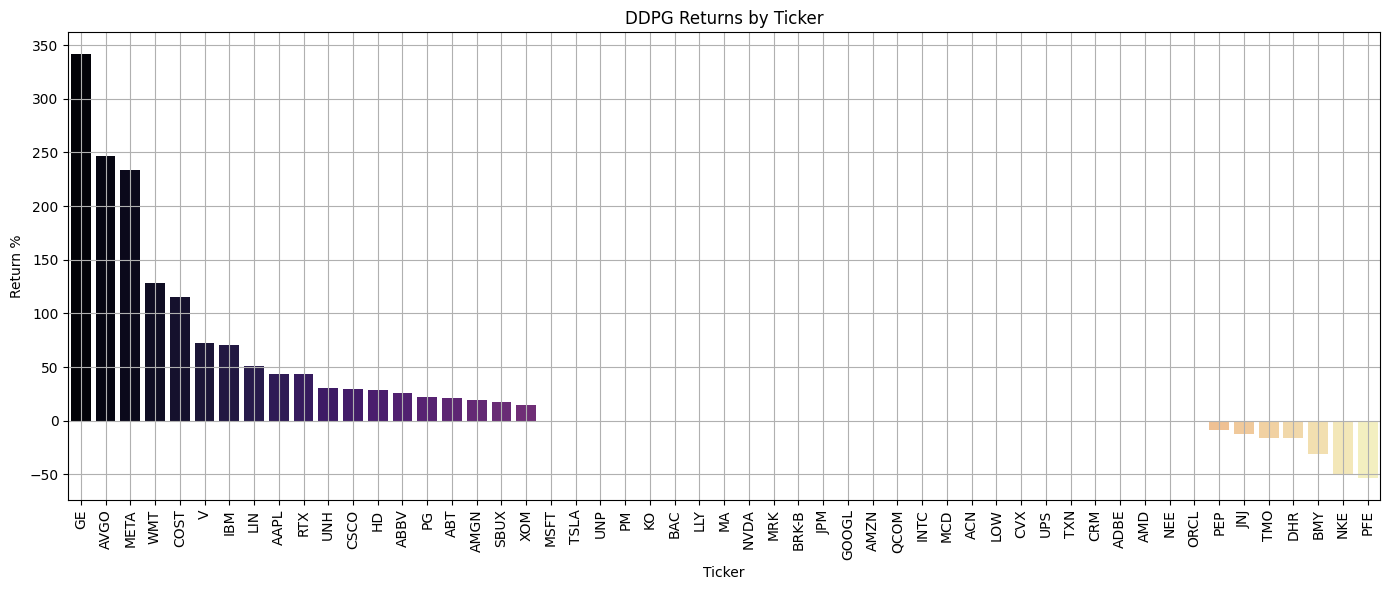

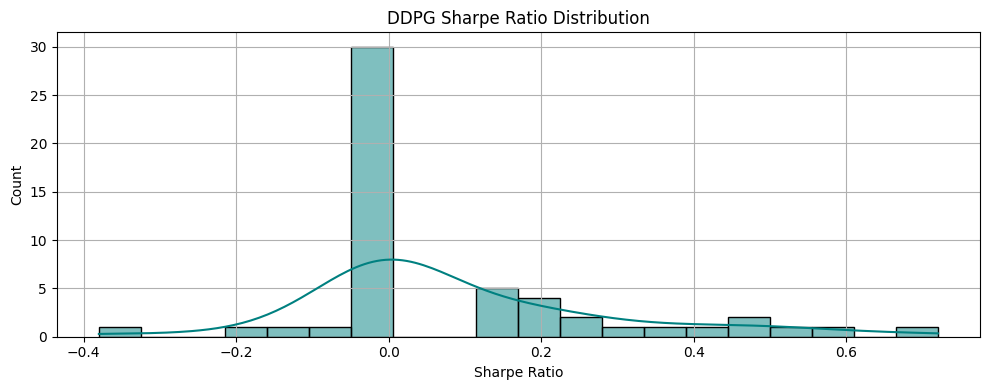

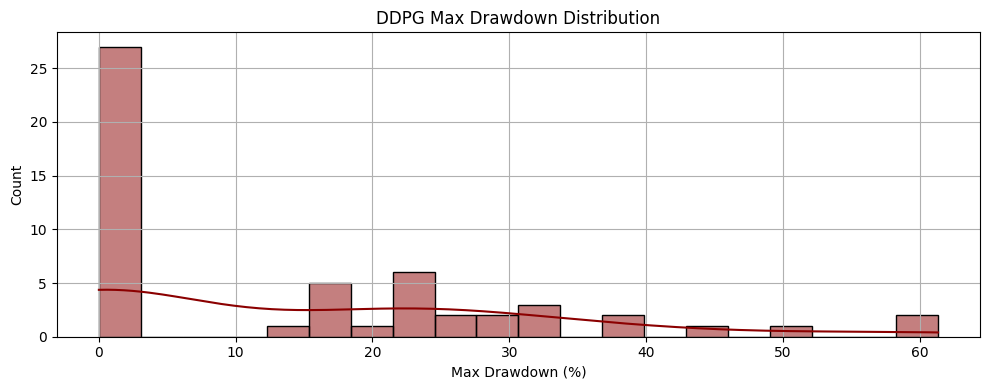

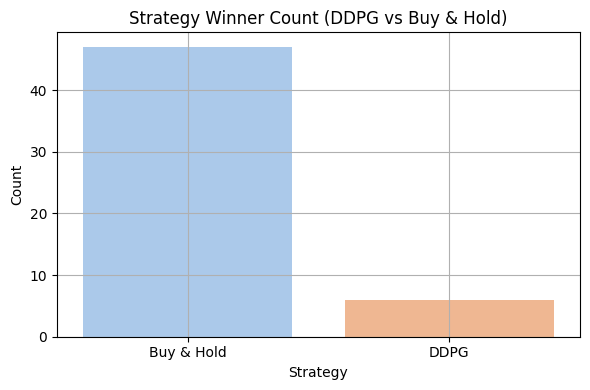

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Load DDPG Results
ddpg_results = pd.read_csv("ddpg_multi_stock_results.csv")

#Sort by Return %
ddpg_results = ddpg_results.sort_values(by="Return %", ascending=False)

#Summary Stats ===
print("\nDDPG Summary Stats")
print(ddpg_results.describe())

#Top 10 Stocks ===
print("\nTop 10 DDPG Stocks by Return %")
print(ddpg_results.head(10)[["Ticker", "Return %", "Sharpe", "Max DD %", "Winner"]])

#Bottom 10 Stocks ===
print("\nBottom 10 DDPG Stocks by Return %")
print(ddpg_results.tail(10)[["Ticker", "Return %", "Sharpe", "Max DD %", "Winner"]])

#Plot 1: Bar Chart of Returns
plt.figure(figsize=(14, 6))
sns.barplot(data=ddpg_results, x="Ticker", y="Return %", palette="magma")
plt.xticks(rotation=90)
plt.title("DDPG Returns by Ticker")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot 2: Sharpe Ratio Distribution
plt.figure(figsize=(10, 4))
sns.histplot(ddpg_results["Sharpe"], bins=20, kde=True, color="teal")
plt.title("DDPG Sharpe Ratio Distribution")
plt.xlabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot 3: Max Drawdown Distribution
plt.figure(figsize=(10, 4))
sns.histplot(ddpg_results["Max DD %"], bins=20, kde=True, color="darkred")
plt.title("DDPG Max Drawdown Distribution")
plt.xlabel("Max Drawdown (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot 4: Win Count Comparison (DDPG vs Buy & Hold)
win_counts = ddpg_results["Winner"].value_counts().reset_index()
win_counts.columns = ["Strategy", "Count"]

plt.figure(figsize=(6, 4))
sns.barplot(data=win_counts, x="Strategy", y="Count", hue="Strategy", palette="pastel", legend=False)
plt.title("Strategy Winner Count (DDPG vs Buy & Hold)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

#Export Top/Bottom Performers
ddpg_results.head(10).to_csv("ddpg_top_10.csv", index=False)
ddpg_results.tail(10).to_csv("ddpg_bottom_10.csv", index=False)
